# MoD AbS

In [260]:
##################################################
# #                 MoD AbS                    # #
# #     modelling disks for HI absorption      # #
# #      fit the line and writes a table       # #
#                                                #
# Filippo Maccagni 24 - 06 - 2016                #
# ASTRON - Kapteyn Institute                     #
##################################################

# import installed python modules
#!/usr/bin/env python
import math
import time
import numpy as np
import string,sys,os
import argparse
import pyfits
import itertools
from astropy import wcs
from astropy.io import fits
from scipy.ndimage.interpolation import zoom
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from pylab import contour,cm,clabel

#load magic python notebook module
#to comment if run from terminal
get_ipython().magic(u'pylab inline')

print'Modules Imported'

###################################################



Populating the interactive namespace from numpy and matplotlib
Modules Imported


`%matplotlib` prevents importing * from pylab and numpy


** PATHS **
    - Root directory
    - Output directory (created if non-existing)
    - Path to continuum image
    - Path to spectrum

In [261]:
#-------------------------------------------------#
#Directories                                      # 
#-------------------------------------------------#

#Galaxy Name
GAL='3C305'

#Root Directory
#directory where the program is located
rootdir=os.path.abspath('')

#Directory for the input files
root_obs=rootdir+'/3c305/'

#Directory for the output files
root_out=rootdir+'/output_3c305/'
try:
    os.stat(root_out)
except:
    os.mkdir(root_out)

#-------------------------------------------------#
#Output table                                     #
#-------------------------------------------------#

#fileinput=sys.argv[1]
#uncomment if loading from terminal#

out_table = rootdir+'/table_out.csv'
    
#-------------------------------------------------#
#Parameter file                                   #
#-------------------------------------------------#

#fileinput=sys.argv[1]
#uncomment if loading from terminal#

fileinput = root_obs+'par_3c305.txt'
 

#-------------------------------------------------#
#Continuum .fits file                             #
#-------------------------------------------------#

#filecont=sys.argv[2]

filecont = root_obs+'3c305.fits'

#-------------------------------------------------#
#Observed spectrum ASCII file                     #
#-------------------------------------------------#

#filespec=sys.argv[3]

filespec = root_obs+'spec_3c305.txt' #spectrum x-axis in Hz

#-------------------------------------------------#
#CONSTANTS                                        #
#-------------------------------------------------#

RAD2DEG=180./math.pi
HI_hz=1.42040575177e9
C=2.99792458E5 

###################################################


** Basic Functions **
    - Read parameter file
    - Write output log table
    - Convert HMS -> degrees
    - Convert DMS -> degrees
    - Convolve with a Gaussian

In [262]:
#-------------------------------------------------#
#Read the parameter file and create a dictionary  #
#-------------------------------------------------#

def readFile(parameterFile):
        
    parameters={}
    
    try:
        paramFile=open(parameterFile)
    except:
        print "%s file not found"  % parameterFile
        return 1
        
    paramList=paramFile.readlines()
    paramFile.close()     

    
    for line in paramList:
        if line.strip():  # non-empty line?
            tmp=line.split('=')
            tmp2=tmp[0].split('[')
            key, value = tmp2[0],tmp[-1]  # None means 'all whitespace', the default
            parameters[key] = value
    
    return parameters

#-------------------------------------------------#
#Write the output table                           #
#-------------------------------------------------#

def writeTable(out_table):
    
    
    #open output table 
    if os.path.exists(out_table) == True: 
        table_out=open(out_table, "aw")
    else:
        table_out=open(out_table, "aw")
        #write title line if table does not exist
        title_line_1='''#RUN,GAL,RA,DEC,z,v_sys[kms],D_L[Mpc],PA_cont[degrees],'''
        title_line_2='''R_max[pc],R_min[pc],H[pc],I[degrees],PA[degrees]'''
        title_line_3='''R_maxD2[pc],R_minD2[pc],H_D2[pc],I_D2[degrees],PA_D2[degrees],'''
        title_line_4='''v_rot[kms],sign[-],v_res[kms],'''
        title_line_5='''res_in[pc],res_fin[pc],med_res,disp_res\n'''

        title_line=title_line_1+title_line_2+title_line_3+title_line_4+title_line_5
        table_out.write(title_line)
        
        
    line_1=str(RUN)+''','''+str(GAL)+''','''+str(RA)+''','''+str(DEC)+''','''
    line_11=str(z_red)+''','''+str(VSYS)+''','''+str(D_L)+''','''+str(PA_C)+''','''   
    line_2=str(RMAX)+''','''+str(RMIN)+''','''+str(H_0)+','+str(I)+','+str(PA)+''','''
    line_3=str(RMAXD2)+''','''+str(RMIND2)+''','''+str(H_0D2)+''','''+str(ID2)+''','''+str(PAD2)+''','''  
    line_4=str(VROT)+''','''+str(SIGN)+''','''+str(2*DISP)+''',''' 
    line_5=str(RES)+''','''+str(RES_FIN)+''','''+str(MED_RES)+''','''+str(DISP_RES)+'''\n'''

    
    line=line_1+line_11+line_2+line_3+line_4+line_5
    table_out.write(line) 
    
    table_out.close()

    return 0

#-------------------------------------------------#
#Coordinates converter                            #
#-------------------------------------------------#

# HMS -> degrees
def ra2deg(rad):
    
        ra=string.split(rad,':')
    
        hh=float(ra[0])*15
        mm=(float(ra[1])/60)*15
        ss=(float(ra[2])/3600)*15
        
        return hh+mm+ss

# DMS -> degrees
def dec2deg(decd):
        dec=string.split(decd,':')
        
        hh=abs(float(dec[0]))
        mm=float(dec[1])/60
        ss=float(dec[2])/3600
        return hh+mm+ss

#-------------------------------------------------#
# Size converter                                  #
#-------------------------------------------------#

# Angle -> radius [Mpc]
def ang2lin(z,dl,ang): # r in arcsec   
    #dl = dl/3.085678e24 # Mpc
    r = ang * dl / (RAD2DEG * 3600 * (1+z)**2) # Mpc
    
    return r
# radius -> angle [arcsec]
def lin2ang(z,dl,r): # r in Mpc

    ang = RAD2DEG * 3600. * r * (1.+z)**2 / dl # arcsec

    return ang

#-------------------------------------------------#
# Gaussian Convolution                            #
#-------------------------------------------------#

def convoluzion(convo):
        mu=0.0        
        arg=-((vels*vels)/(2*DISP*DISP))
        gauss=1./(np.sqrt(2*np.pi)*DISP)*np.exp(arg)
        convolved_pdf=np.convolve(convo,gauss,mode='same')
         
        return convolved_pdf
    
###################################################



** FUNCTIONS of the MODEL **

    - Load continuum image and interpolate to initial resolution
    - Define the disk
    - Compute integrated absorption line for each disk and merge them together

In [263]:
#-------------------------------------------------#
#Continuum CUBE: Input for the absorption        #
#-------------------------------------------------#

def build_continuum(x_los,y_los):
        
        #Load continuum: 
        f=pyfits.open(filecont)
        dati=f[0].data
        head=f[0].header
        dati=np.squeeze(dati)
        dati=np.squeeze(dati)

        # define the resolution of the continuum image
        scale_cont_asec=head['CDELT2']*3600
        scale_cont_pc=ang2lin(z_red,D_L,scale_cont_asec)*1e6


        #load the continuum image
        head=fits.getheader(filecont)
        del head['CTYPE4']
        del head['CDELT4']    
        del head['CRVAL4']
        del head['CRPIX4']
        del head['CRPIX3'] 
        del head['CRVAL3']
        del head['CDELT3']
        del head['CTYPE3']
        del head['NAXIS3']
        del head['NAXIS4']        
        del head['NAXIS']
        del head['CROTA1']
        del head['CROTA2']
        del head['CROTA3']
        del head['CROTA4']


        w=wcs.WCS(head)    
        
        #convert coordinates in pixels
        #cen_x,cen_y=w.wcs_world2pix(ra,dec,0)
        cen_x,cen_y=w.wcs_world2pix(ra,dec,1)
        
        print '\tContinuum centre [pixel]:\t'+'x: '+str(cen_x)+'\ty: '+str(cen_y) 
        print '\tContinuum pixel size [pc]:\t'+str(scale_cont_pc)+'\n'
        
        
        #deterimne the edges of the output cube 
        #on the continuum image
        x_los_num_right=x_los[-1]/scale_cont_pc
        x_los_num_left=x_los[0]/scale_cont_pc
        y_los_num_up=y_los[-1]/scale_cont_pc
        y_los_num_low=y_los[0]/scale_cont_pc
        
        y_up=cen_y+y_los_num_up
        x_right=cen_x+x_los_num_right
        y_low=cen_y+y_los_num_low
        x_left=cen_x+x_los_num_left
        
        #approximate
        x_left_int=math.modf(x_left)
        x_right_int=math.modf(x_right)
        y_low_int=math.modf(y_low)
        y_up_int=math.modf(y_up)
        
        #select the continuum subset
        sub_dati=dati[int(y_low_int[1]):int(y_up_int[1]),int(x_left_int[1]):int(x_right_int[1])]

        if sub_dati.shape[0] != sub_dati.shape[1]:
            sub_dati=dati[int(y_low_int[1]):int(y_up_int[1])-1,int(x_left_int[1]):int(x_right_int[1])]
            
        
        #determine how much I have to interpolate     
        zoom_factor= float(len(x_los))/float(len(sub_dati[0]))
        
        #interpolate to the desired resolution of the cycle 1 cube
        zoom_dati=zoom(sub_dati,zoom_factor,order=3)
                               
        return zoom_dati
    
#-------------------------------------------------#
#Function for the DISK coordinates and velocity   #
#-------------------------------------------------#

def space(z_cube,y_cube,x_cube,continuum_cube,rmax,rmin,h_0,pa,i):  
    
#-------------------------------------------------#
#takes an input cube in space coordinates and the # 
#continuum cube returns the cube of velocities    #
#of the disk and the continuum cube with values   # 
# only where there is absorption                  #
#-------------------------------------------------#


        #trigonometric parameters of the disk
        i_rad=math.radians(i)
        pa_rad=math.radians(pa)

        #Disk
        cos_i = np.cos(i_rad)
        sin_i = np.sin(i_rad)
        cos_pa = np.cos(pa_rad)
        sin_pa = np.sin(pa_rad)

        #convert into disk coordinates
        x=cos_pa*x_cube+sin_pa*y_cube
        y=cos_i*(-sin_pa*x_cube+cos_pa*y_cube)+sin_i*z_cube  
        z=-sin_i*(-sin_pa*x_cube+cos_pa*y_cube)+cos_i*z_cube
         

        #determine the radius of the disk    
        r=np.sqrt(np.power(x,2)+np.power(y,2))
        angle=np.arctan2(y,x)        
       
        #define the cube of velocities 
        vel=-SIGN*sin_i*np.cos(angle)*VROT
        
        #for plotting: define the disk in front of the continuum
        disk_front=vel.copy()
        
        index_vel= (continuum_cube == 0.0)
        vel[index_vel]=-np.inf
        
        #condition for DISK 1
        idx = ( (r > rmax) |  (r<rmin) | (abs(z)>=h_0/2.) )
        #set to zero or -999 the flux and velocities outside the disk
        continuum_cube[idx] = 0.0
        vel[idx]= -np.inf
        disk_front[idx]= -999.

        
        #set to non good values what is behind the continuum
        #for plotting: define the disk behind the continuum
        disk_behind=disk_front.copy()
        
        #determine what is in front and what behind the continuum
        index_abs = (z_cube>(np.tan(PA_C_rad)*x_cube))
        
        #modify the cubes: bad values for what is behind
        vel[index_abs] = -np.inf        
        continuum_cube[index_abs] = 0.0
        disk_front[index_abs]=-999.

        index_abs = (z_cube<(np.tan(PA_C_rad)*x_cube))
        
        disk_behind[index_abs]=-999.
        
        #for plotting: exclude the absorbed section from the disk in front
        disk_ind= ((vel >= -VROT) & (vel <= VROT) )
        disk_front[disk_ind]= -999.
        
        return vel,continuum_cube,disk_front,disk_behind


#-------------------------------------------------#
#Function computing absorption for each disk     #  
#-------------------------------------------------#

def mod_abs(z_cube,y_cube,x_cube,continuum_cube_z,flag):
 
    #-------------------------------------------------#
    # Load the parameters for the right disk          #
    #-------------------------------------------------#       
    
    #flag=2 inner second disk
    if flag == int(2):
        rmax=float(par.get('rmax_in'))
        rmin=float(par.get('rmin_in'))
        h_0=float(par.get('h0_in'))
        i=float(par.get('i_in'))
        pa=float(par.get('pa_in'))    

    #flag=1 outer first (or only) disk
    if flag == int(1):
        rmax=float(par.get('rmax'))
        rmin=float(par.get('rmin'))
        h_0=float(par.get('h0'))
        i=float(par.get('i'))
        pa=float(par.get('pa'))
        
        
    #-------------------------------------------------#
    # VELOCITY and FLUX of the absorbed disk          #
    #-------------------------------------------------#                    
    
    velocity,flusso,disk_front,disk_behind = space(z_cube,y_cube,x_cube,continuum_cube_z,rmax,rmin,h_0,pa,i)
    
    #-------------------------------------------------#
    # INTERPOLATE to final RESOLUTION                 #
    #-------------------------------------------------#
    
    print '...start interpolation...\n'

    #determine the factor for the interpolation depending on 
    #the specified resolutions
    
    factor=RES/RES_FIN

    print '\tInterpolation of a factor:\t'+str(factor)+'\n'

    #increase the order for non-linear interpolation
    vel_zoom = zoom(velocity, factor,order=ORDER)
    flux_zoom = zoom(flusso, factor, order=ORDER)

    print '...end interpolation...\n'

    
    #-------------------------------------------------#
    # BIN the CUBE in the Integrated spectrum         #
    #-------------------------------------------------#
    
    print '...start binning...\n'
    
    #select velocities and fluxes which belong to the disk
    vel_index= ((vel_zoom >= -VROT) & (vel_zoom <= VROT) )

    #straighten the array
    lin_vel=vel_zoom[vel_index]
    lin_flux=flux_zoom[vel_index]
    
    #determine the integrated spectrum
    spec=np.zeros([len(vels)])
    for i in xrange(0,len(vels)-1):
        #look for the right velocity bin
        index=(vels[i]<=lin_vel) & (lin_vel < vels[i+1])
        #update the flux bin
        spec[i]=-np.sum(lin_flux[index])
    
    print '...end binning...\n'


    #-------------------------------------------------#
    # CLEAN the CUBE of useless values                #
    #-------------------------------------------------#
    #clean the flux and velocity cube after the interpolation
    #for plotting:
    
    #absorbed part of the disk
    vel_ind = velocity == -np.inf
    velocity[vel_ind] = np.nan
    
    #disk in front of continuum
    disk_ind = disk_front == -999.
    disk_front[disk_ind] = np.nan
    
    #disk behind continuum
    disk_ind = disk_behind == -999.
    disk_behind[disk_ind] = np.nan
    
    return spec,velocity,disk_front,disk_behind


#-------------------------------------------------#
#CHI2 and RESIDUAL spectrum                       #
#-------------------------------------------------#
def chi_res(s_mod,s_obs):
    
    #interpolate to have arrays all of the same length
    func_obs= interp1d(s_obs[:,0],s_obs[:,1])
    func_mod= interp1d(s_mod[0,:],s_mod[1,:])
    
    #create a new array long enough
    vel_int=np.arange(-VROT,VROT+DISP,2.*DISP)
    
    #determine the fluxes of observed 
    #and modelled spectra
    
    obs_int=func_obs(vel_int)
    mod_int=func_mod(vel_int)

    #determine residuals array
    res=obs_int-mod_int

    #set arrays for output
    res_out=np.array([vel_int,res])
    obs_out=np.array([vel_int,obs_int])
    mod_out=np.array([vel_int,mod_int])

    
    # some STATISTICS on the residuals
    
    disp_res=np.std(res[~np.isnan(res)])
    med_res=np.median(res[~np.isnan(res)])
    
    
    return res_out,obs_out,mod_out,med_res,disp_res
    

###################################################


** Input PARAMETERS of the DISK **
    - variables from the parameter file
    - velocity array
    - cube
    - output image filename

In [214]:
#-------------------------------------------------#
#SET the VARIABLES                                #
#-------------------------------------------------#

#Call the function and set the dictionary
par=readFile(fileinput)

# Disk 1 
RMAX=float(par.get('rmax'))                   #Maximum radius [pc]
RMIN=float(par.get('rmin'))                   #Minimum radius [pc]
H_0=float(par.get('h0'))                      #Thickness [pc]
I=float(par.get('i'))                         #Inclination [degrees]
PA=float(par.get('pa'))                       #Position angle [degrees]

#Disk 2 
# !!! RMAXD2 < RMAX !!! #
RMAXD2=float(par.get('rmax_in'))
RMIND2=float(par.get('rmin_in'))
H_0D2=float(par.get('h0_in'))
ID2=float(par.get('i_in'))
PAD2=float(par.get('pa_in'))

# Rotation Curve
VROT=float(par.get('vrot'))                   #Flat limit of the rotation curve [km/s]
SIGN=float(par.get('sign'))                   #Direction of rotation [=/- 1]

# Continuum information
PA_C=float(par.get('pa_cont'))                #Position angle of the continuum [degrees]
CONT_LIM=float(par.get('flux_cont_lim'))      #Noise limit: sets the region of the absorption !!!
VSYS=float(par.get('v_sys'))                  #Systemic velocity [km/s]
D_L=float(par.get('d_l'))                     #luminosity distance [Mpc]
z_red=float(par.get('z'))                     #redshift
RA=par.get('ra')                              #Right Ascention 
DEC=par.get('dec')                            #Declination

RA=string.strip(RA)
DEC=string.strip(DEC)

# Resolution Information
RES=float(par.get('pix_res'))                 #Resolution 1st cycle  [pc]
RES_FIN=float(par.get('pix_res_fin'))         #Final resoluion   [pc]
VRES=float(par.get('vel_res'))                #Velocity resolution for binning [km/s]
DISP=float(par.get('disp'))                   #Dispertion for final resolution (~ to observed spectrum) [km/s]
ORDER=int(par.get('order'))                   #Order of spline for interpolation

#galaxy name in the parameter dictionary
par['gal'] = GAL

#-------------------------------------------------#
#Print variables                                  #
#-------------------------------------------------#

print '********************\n'
print 'INPUT PARAMETERS\n'
print '********************\n'
for keys,values in par.items():
    print keys+' = '+str(values)
print '********************\n'   

#-------------------------------------------------#
#Convert coordinates                              #
#-------------------------------------------------#

#convert to degrees
ra=ra2deg(RA)
dec=dec2deg(DEC)
#convert degrees to radians
PA_C_rad=math.radians(PA_C)

#-------------------------------------------------#
#CUBE                                             #
#-------------------------------------------------#

print 'INPUT DISK\n'
print '********************\n'   

#build the cube which contains my disk based on its (RMAX)
#and on the resolution of the 1st cycle

#set the edges to RMAX+20%
x_los=np.arange(-RMAX*1.2,+RMAX*1.2+RES,RES)
y_los=np.arange(-RMAX*1.2,+RMAX*1.2+RES,RES)
z_los=np.arange(-RMAX*1.2,+RMAX*1.2+RES,RES)

#edges of the cube
print 'edges of the cube [pc]:\t\t\t'      +str(x_los[-1]),str(x_los[0])
print 'size of the cube [pixels]]:\t\t'  +str(len(x_los))+' x '+str(len(y_los))+' x '+str(len(z_los))
print 'resolution first cycle [pc]:\t\t' +str(RES)+'\n'

#-------------------------------------------------#
#INTEGRATED spectrum                              #
#-------------------------------------------------#
#                                                 #
#input integrated spectrum:                       #
#velocity = bins of desired resolution            #
#define the output integrated spectrum            #
#one bin must include zero (zero not an edge!!!)  #
#                                                 #
#-------------------------------------------------#

vels=np.arange(-VROT*2.,VROT*2.+VRES,VRES)-VRES/2.
spec_int=np.zeros([2,len(vels)])
spec_int[0,:]=vels[:]

#edges of the velocity array
print 'edges of the velocity array [km/s]:\t' + str(vels[-1]),str(vels[0])
print 'velocity resolution [km/s]:\t\t' + str(VRES)
print 'convolved velocity resolution [km/s]:\t' + str(2.*DISP)+'\n'
print '********************\n'   




********************

INPUT PARAMETERS

********************

disp =   8. 

h0 =  200.

flux_cont_lim =   0.130

sign =   -1.

pix_res =   50.

dec =   +63:16:13.78

h0_in =  200.

rmin =   2000.

i_in =   +35

vrot =   280.

pa =  -27.0

ra =   +14:49:21.57

vel_res =   1.

rmax =   3000.

pa_in =   -10.

pix_res_fin =   20.

gal = 3C305
rmax_in =   2000.

rmin_in =   0.

i = +55.

v_sys =  12480

pa_cont =   +60.

d_l =  184.127

z =  0.041639

order =  1

********************

INPUT DISK

********************

edges of the cube [pc]:			3600.0 -3600.0
size of the cube [pixels]]:		145 x 145 x 145
resolution first cycle [pc]:		50.0

edges of the velocity array [km/s]:	559.5 -560.5
velocity resolution [km/s]:		1.0
convolved velocity resolution [km/s]:	16.0

********************



** MAIN **
    - create cube of continuum
    - create cube of coordinates
    - compute integrated spectrum
    - compute cubes of
        - absorbed disk
        - disk in front of continuum
        - disk behind continuum
    - convolve integrated spectrum
    - normalize spectrum to peak of observed spectrum

In [233]:
#-------------------------------------------------#
#MAIN MAIN MAIN                                   #
#-------------------------------------------------#

print '********************\n'   
print '...Begin...\n'

#start timer
tempoinit=time.time()

#-------------------------------------------------#
#Set the input continuum cube                     # 
#-------------------------------------------------#

print '... set continuum input cube...\n'

#load the continuum image interpolated at the specified resolution
continuum_image=build_continuum(y_los,x_los)

#to use for uniform absorption 
#continuum_image=np.zeros([len(x_los),len(y_los)])+1.

#create a cube containing the fluxes of the continuum image

#-------------------------------------------------#
# Based on the coordinate system of the README    # 
# the axis are sorted in the array: [y,z,x]       #
#-------------------------------------------------#

continuum_cube_z=np.dstack([continuum_image]*(len(z_los)))
continuum_cube_z=np.swapaxes(continuum_cube_z,1,2)

#mask the noise of the continuum in the cube
index_mask = continuum_cube_z < CONT_LIM
continuum_cube_z[index_mask] = 0.0
continuum_cube_z2 = continuum_cube_z.copy()

#mask the noise of the continuum in the continuum image
index_mask = continuum_image < CONT_LIM        
continuum_image[index_mask] = 0.0


#-------------------------------------------------#
#Set the input coordinates cube                  #
#-------------------------------------------------#

print '...set disk...\n'

#create a meshgrid for the cube
z_cube,y_cube,x_cube = np.meshgrid(z_los,y_los,x_los)


#-------------------------------------------------#
#Compute absorption                              #
#-------------------------------------------------#

print '...compute absorption for disk 1...\n'

#compute the spectrum and the cubes
spec_integral,velocity,disk_front,disk_behind=mod_abs(z_cube,y_cube,x_cube,continuum_cube_z,int(1))

#-------------------------------------------------#
#2 DISK CASE                                     #
#-------------------------------------------------#

if RMAXD2 != 0.0 :
    print '...compute absorption for disk 2...\n'

    #compute the second set of lines and cubes and 
    #merge them with the first set
    spec_int_2,velocity_2,disk_front_2,disk_behind_2=mod_abs(z_cube,y_cube,x_cube,continuum_cube_z2,int(2))
    
    #merge absorbed cubes
    velocity=np.nan_to_num(velocity)
    velocity_2=np.nan_to_num(velocity_2)
    velocity=np.add(velocity,velocity_2) 
    velocity[velocity==0.0]=np.nan

    #merge disks in front
    disk_front=np.nan_to_num(disk_front)
    disk_front_2=np.nan_to_num(disk_front_2)
    disk_front=np.add(disk_front,disk_front_2)    
    disk_front[disk_front==0.0]=np.nan
        
    #merge disks behind
    disk_behind=np.nan_to_num(disk_behind)
    disk_behind_2=np.nan_to_num(disk_behind_2)
    disk_behind=np.add(disk_behind,disk_behind_2)    
    disk_behind[disk_behind==0.0]=np.nan

    #merge spectrum
    spec_integral[:]+=spec_int_2[:]

#set final integrated spectrum
spec_int[1,:]=spec_integral[:]   
    
#-------------------------------------------------#
#CONVOLVE the SPECTRUM                            #
#-------------------------------------------------#

print '...convolve spectrum...\n'

#convolve the spectrum at the desired velocity resolution
spec_int[1,:]=convoluzion(spec_int[1,:])

#-------------------------------------------------#
#NORMALIZE the SPECTRUM to the OBSERVED one       #
#-------------------------------------------------#
    
print '...normalize spectrum...\n'

#load observed spectrum
spec_obs=np.loadtxt(filespec)
#convert in frequency given the systemic velocity
spec_obs[:,0]=(HI_hz/spec_obs[:,0]-1)*C
spec_obs[:,0]=spec_obs[:,0]-VSYS
        
#normalize modelled spectrum to observed one
peak_obs=np.min(spec_obs[:,1])
peak_mod=np.min(spec_int[1,:])

spec_int_norm=np.divide(spec_int[1,:],peak_mod)
spec_int_mod=np.multiply(spec_int_norm,peak_obs)

#-------------------------------------------------#
#Determine residuals and chi2                     #
#-------------------------------------------------#

print '...compute some stats...\n'

spec_full=np.array([vels,spec_int_mod])

residuals,obs_res,mod_res,MED_RES,DISP_RES=chi_res(spec_full,spec_obs)

par['med_res'] = str(MED_RES)
par['disp_res'] = str(DISP_RES)


#-------------------------------------------------#
#Write new line in output table                   #
#-------------------------------------------------#
print '...write table some stats...\n'

RUN=1

writeTable(out_table)






print '...End... \n'

tempofin=(time.time()-tempoinit)/60.
tempoinit=tempofin

print '********************'   
print "\tTotal time: %f minutes" % (tempofin)  

print '********************'   
print 'NORMAL TERMINATION'
print '********************\n' 

  

###################################################


********************

...Begin...

... set continuum input cube...

	Continuum centre [pixel]:	x: 131.86043103	y: 128.270052589
	Continuum pixel size [pc]:	255.322615912

...set disk...

...compute absorption for disk 1...

...start interpolation...

	Interpolation of a factor:	2.5

...end interpolation...


/Library/Python/2.7/site-packages/ipykernel/__main__.py:215: RuntimeWarning: invalid value encountered in greater_equal
/Library/Python/2.7/site-packages/ipykernel/__main__.py:215: RuntimeWarning: invalid value encountered in less_equal



...start binning...

...end binning...

...compute absorption for disk 2...

...start interpolation...

	Interpolation of a factor:	2.5

...end interpolation...

...start binning...

...end binning...

...convolve spectrum...

...normalize spectrum...

...End... 

********************
	Total time: 0.242059 minutes
********************
NORMAL TERMINATION
********************



** DETERMINE RESIDUALS and CHI2 **

...compute some stats...

NORMAL TERMINATION


** PLOT SPECTRUM and DISK **

In [258]:
#-------------------------------------------------#
# PLOT function                                   #
#-------------------------------------------------#

def plot_figure(spec_obs,spec_int,res,mod,obs,outfile_fig,flusso,continuum_image,disk_front,disk_behind):
  
    #set limits of images
    #spectrum limits [km/s]
    xleft=-VROT*3
    xright=VROT*3
    
    yup=np.max(spec_obs[:,1]*1.05)
    ydown=np.min(spec_obs[:,1]*1.05)

    #enlarge limits of the modelled spectrum
    vels_enl=np.arange(xleft,xright+VRES,VRES)
    spec_enl=np.zeros(len(vels_enl))
    
    left=(len(vels_enl)-len(vels))/2
    right=len(vels_enl)-left
    
    spec_enl[left:right]=spec_int[:]
    spec_enl[left-1]=spec_int[0]/2.
    spec_enl[right+1]=spec_int[-1]/2.
    
    #define figure parameters  
    params = {'legend.fontsize': 14,
           'axes.linewidth':2,
            'axes.labelsize':22,
           'lines.linewidth':1,
           'legend.linewidth': 3,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})
    plt.rcParams.update(params)
          

    #-------------------------------------------------#
    # Set FIGURE and GRID                             #
    #-------------------------------------------------#
    
    fig_a = plt.figure(figsize=(18, 18), dpi=100)

    #set the FULL grid
    gs_all = gridspec.GridSpec(2, 1)
    gs_all.update(left=0.1, right=0.9, wspace=0.0,hspace=0.00)
    
    #set the grid for the spectrum and the projected cube
    gs_spec = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_all[0], wspace=0.0, hspace=0.0)
    gs_ort = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_all[1], wspace=0.2, hspace=0.0)

    
    #-------------------------------------------------#
    # Plot the spectrum and parameters of the disk    #
    #-------------------------------------------------#
    
    #define plots
    ax_spec=fig_a.add_subplot(gs_spec[0:2, 0:2])
    ax_par=fig_a.add_subplot(gs_spec[0:3, 2])
    ax_res=fig_a.add_subplot(gs_spec[2, 0:2])

    
    #-------------------------------------------------#
    # Spectrum                                        #
    #-------------------------------------------------#  
    
    #plot the observed and modelled spectra
    ax_spec.plot(spec_obs[:,0],spec_obs[:,1],ls='-',c='black',label=r'WSRT',marker=' ',lw=3)
    ax_spec.plot(vels_enl,spec_enl,ls='-',c='red',label=r'model',marker=' ',lw=2)

    ax_spec.plot(obs[0,:],obs[1,:],ls='-',c='blue',marker=' ',lw=2)

    
    #plot residuals and observed spectrum
    ax_res.plot(spec_obs[:,0],spec_obs[:,1],ls='-',c='black',label=r'WSRT',marker=' ',lw=3)
    ax_res.plot(res[0,:],res[1,:],ls='-',c='orange',label=r'residuals',marker=' ',lw=3)

    
    #plot horizontal line at zero
    xx=[xleft,xright]
    yy=[0.,0.]
    ax_spec.plot(xx,yy,ls='--',lw=1,color='black')
    ax_res.plot(xx,yy,ls='--',lw=1,color='black')

    #plot vertical line at zero
    xx=[0.,0.]
    yy=[ydown,yup]
    ax_spec.plot(xx,yy,ls='--',lw=1,color='black')
    ax_res.plot(xx,yy,ls='--',lw=1,color='black')

    #plot vertical line at edges of rotation curve
    xx=[res[0,0],res[0,0]]
    yy=[ydown,yup]
    ax_res.plot(xx,yy,ls='--',lw=1,color='black')   
    xx=[res[0,0-1],res[0,-1]]
    yy=[ydown,yup]
    ax_res.plot(xx,yy,ls='--',lw=1,color='black')      
    
    #set limits of image
    ax_spec.set_xlim(xleft,xright)
    ax_spec.set_ylim(ydown,yup)

    ax_res.set_xlim(xleft,xright)
    ax_res.set_ylim(ydown,yup)

    
    #set labesl of spectrum
    ax_spec.set_ylabel(r'Flux\, [Jy]')
    ax_spec.legend(loc=4)

    ax_res.legend(loc=4)

    ax_res.set_xlabel(r'Velocity [km\,s$^{-1}$]')

    #set title
    ax_spec.set_title('Spectrum',fontsize=22)


    #-------------------------------------------------#
    # Disk parameters                                 #
    #-------------------------------------------------#    
    
    #plot box with parameters
    ax_par.text(0.1, 0.94, r' r$_{\rm in}$\,(max)\,\,=\,'+str(RMAX)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.87, r' r$_{\rm in}$\,(min)\,\,=\,'+str(RMIN)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.80, r' h$_{\rm in}$\,\,\,=\,'+str(H_0)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.73, r' pa$_{\rm in}$\,\,=\,'+str(PA)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.66, r' i$_{\rm in}$\,\,=\,'+str(I)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.59, r' r$_{\rm out}$\,(max)\,\,=\,'+str(RMAXD2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.52, r' r$_{\rm out}$\,(min)\,\,=\,'+str(RMIND2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.45, r' h$_{\rm out}$\,\,\,=\,'+str(H_0D2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.38, r' pa$_{\rm out}$\,\,=\,'+str(PAD2)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.31, r' i$_{\rm out}$\,\,=\,'+str(ID2)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.24, r' v\,(rot)\,\,=\,'+str(VROT)+r'\,\,km\,s$^{-1}$', fontsize=14)
    ax_par.text(0.1, 0.17, r' pa \,(cont)\,\,=\,'+str(PA_C)+r'\,\,$^\circ$', fontsize=14)

    ax_par.text(0.1, 0.10, r' med \,res\,\,=\,'+str(round(MED_RES,5))+r'\,\,Jy', fontsize=14)
    ax_par.text(0.1, 0.03, r' disp \,res\,\,=\,'+str(round(DISP_RES,5))+r'\,\,Jy', fontsize=14)

    #ax_par.text(0.1, 0.2, r' RA\,\,=\,'+RA, fontsize=16)
    #ax_par.text(0.1, 0.1, r' DEC \,\,=\,'+DEC, fontsize=16)
    
    #set ticks
    ax_par.set_xticks([])
    ax_par.set_yticks([])
    #set title
    ax_par.set_title('Disk parameters',fontsize=22)
 

    #-------------------------------------------------#
    # Plot the cube in different projections          #
    #-------------------------------------------------#
    
    #define plots
    ax_pv = fig_a.add_subplot(gs_ort[0,0]) 
    ax_po = fig_a.add_subplot(gs_ort[0,1])
    ax_pl = fig_a.add_subplot(gs_ort[0,2])
    
    
    #-------------------------------------------------#
    # PLANE of the SKY                                #
    #-------------------------------------------------#
    
    #project the fluxes of the absorbed cube
    flux_zoom_pv=np.nanmean(flusso,axis=1)
    disk_front_pv=np.nanmean(disk_front,axis=1)
    disk_behind_pv=np.nanmean(disk_behind,axis=1)
    
    #plot continuum image
    ax_pv.imshow(continuum_image,extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],origin='lower',cmap='hot_r',alpha=0.8)
    cont=[CONT_LIM]
    ax_pv.contour(continuum_image,cont,origin='lower',
                     colors='black',linewidths=3,ls='-.',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]])

    #plot absorbed part of the disk
    ax_pv.imshow(flux_zoom_pv,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=1.)   

    #plot disk in front of continuum
    ax_pv.imshow(disk_front_pv,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.1)   
    #plot disk in behind continuum
    ax_pv.imshow(disk_behind_pv,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.4)   
    
    #set ticks
    ax_pv.set_xlabel(r'x [kpc]')
    ax_pv.set_ylabel(r'y [kpc]')
    ax_pv.set(adjustable='box-forced', aspect='equal')
    #ax_pv.set_xticklabels([-4,-3,-2,-1,0,1,2,3])
    #ax_pv.set_yticklabels([-4,-3,-2,-1,0,1,2,3])    
    #set title
    ax_pv.set_title('Plane of the sky',fontsize=22)

    
    #-------------------------------------------------#
    # View from above                                 #
    #-------------------------------------------------#

    #project the fluxes of the absorbed cube
    flux_zoom_po=np.nanmean(flusso,axis=0)
    disk_front_po=np.nanmean(disk_front,axis=0)
    disk_behind_po=np.nanmean(disk_behind,axis=0)

    #plot absorbed part of the disk
    ax_po.imshow(flux_zoom_po,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=1.)     
    
    #plot disk in front of continuum
    ax_po.imshow(disk_front_po,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.1)   
    #plot disk in behind continuum
    ax_po.imshow(disk_behind_po,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.4)   

    #set ticks
    ax_po.set_xlabel(r'x [kpc]')
    ax_po.set_ylabel(r'z [kpc]')
    ax_po.set(adjustable='box-forced', aspect='equal')
    #ax_po.set_yticks([])
    #ax_po.set_xticklabels([-4,-3,-2,-1,0,1,2,3])
    #ax_po.set_yticklabels([-4,-3,-2,-1,0,1,2,3])
    
    #set title
    ax_po.set_title('View from `above`',fontsize=22)   

    
    #-------------------------------------------------#
    # View from the side                              #
    #-------------------------------------------------#
    
    #project the fluxes of the absorbed cube
    flux_zoom_pl=np.nanmean(flusso,axis=2)
    disk_front_pl=np.nanmean(disk_front,axis=2)
    disk_behind_pl=np.nanmean(disk_behind,axis=2)

    #plot absorbed part of the disk
    ax_pl.imshow(flux_zoom_pl.T,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=1.) 
      
    #plot disk in front of continuum
    ax_pl.imshow(disk_front_pl.T,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.1)   
    #plot disk in behind continuum
    ax_pl.imshow(disk_behind_pl.T,origin='lower',cmap='nipy_spectral',extent=[x_los[0],x_los[-1],y_los[0],y_los[-1]],alpha=0.4)  

    
    #set ticks
    ax_pl.set_xlabel(r'z [kpc]')
    ax_pl.set_ylabel(r'y [kpc]')
    ax_pl.set(adjustable='box-forced', aspect='equal')
    #ax_pl.set_yticks([])
    #ax_pl.set_xticklabels([-4,-3,-2,-1,0,1,2,3])
    #ax_pl.set_yticklabels([-4,-3,-2,-1,0,1,2,3])
    #set title
    ax_pl.set_title('View from `the side`',fontsize=22)     
   

    #-------------------------------------------------#
    # Save figure                                     #
    #-------------------------------------------------#   
    
    fig_a.savefig(outfile_fig,format='png',bbox_inches='tight')
    
    return 0

...Begin Plotting...

...End Plotting...



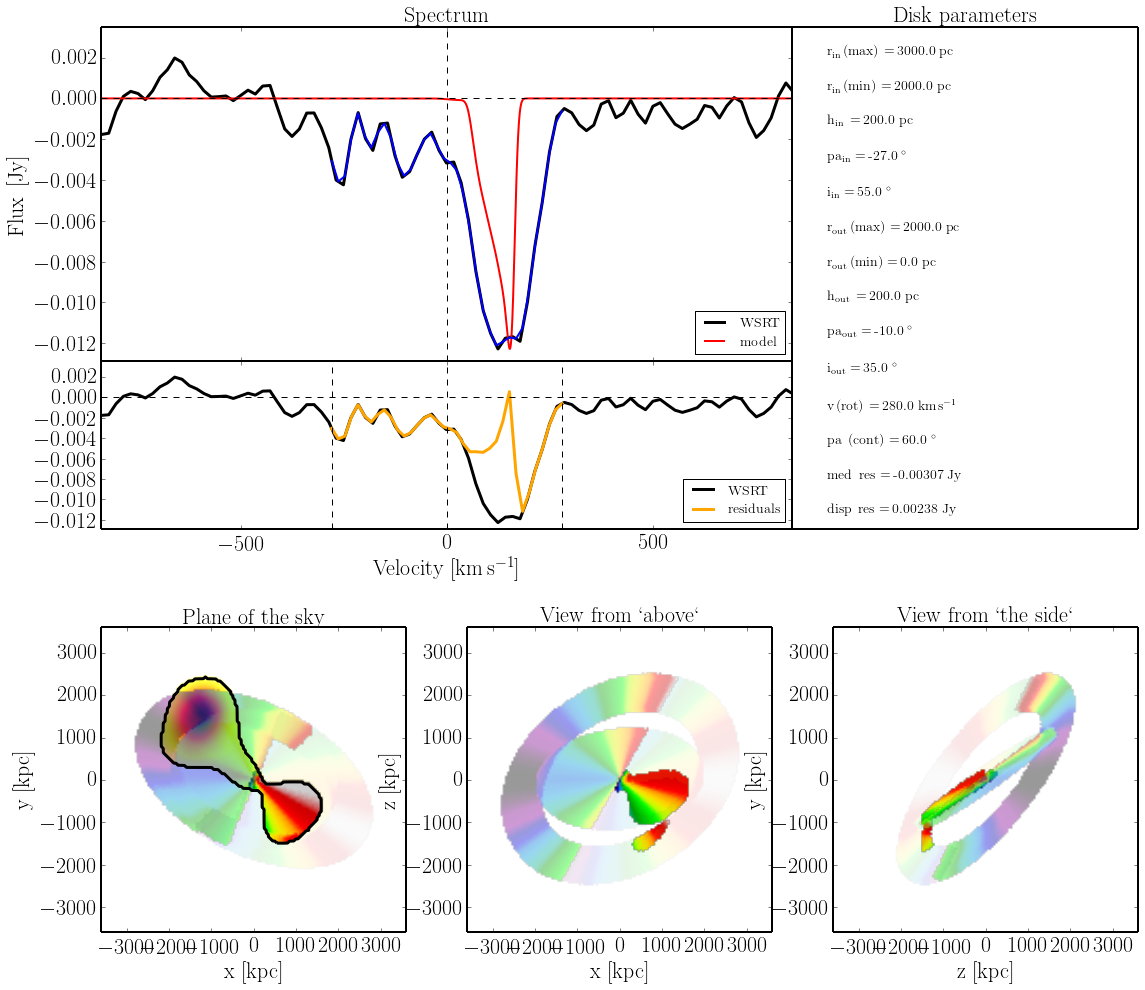

In [259]:
#-------------------------------------------------#
# PLOT                                            #
#-------------------------------------------------#

#-------------------------------------------------#
#Output FIGURE                                    #
#-------------------------------------------------#

#define smart names for the output figure
outfile_fig=root_out+'spec_fit'+str(int(I))+'_'+str(int(PA))+'.png'


print '...Begin Plotting...\n'

plot_figure(spec_obs,spec_int_mod,residuals,mod_res,obs_res,outfile_fig,velocity,continuum_image,disk_front,disk_behind)

print '...End Plotting...\n'


###################################################
# END                                             #
###################################################

